In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/Untitled0.ipynb
/content/drive/MyDrive/Untitled3.ipynb
/content/drive/MyDrive/주인주.ipynb
/content/drive/MyDrive/Untitled1.ipynb
/content/drive/MyDrive/Untitled4.ipynb
/content/drive/MyDrive/Ex 4-1 k-means clustering.ipynb
/content/drive/MyDrive/Untitled5.ipynb
/content/drive/MyDrive/Untitled6.ipynb
/content/drive/MyDrive/classification CNN.ipynb
/content/drive/MyDrive/word prediction RNN.ipynb
/content/drive/MyDrive/Untitled8.ipynb
/content/drive/MyDrive/Untitled (1)
/content/drive/MyDrive/HW_RRT.ipynb
/content/drive/MyDrive/HW_RRT_유지강 (1).ipynb
/content/drive/MyDrive/RRT_ref (1).ipynb
/content/drive/MyDrive/RRT_ref.ipynb_주인주.ipynb
/content/drive/MyDrive/Untitled10.ipynb
/content/drive/MyDrive/Untitled12.ipynb
/content/drive/MyDrive/중간고사대체_주인주 (1).docx
/content/drive/MyDrive/중간고사대체_주인주.docx
/content/drive/MyDrive/출설.pdf
/content/drive/MyDrive/Untitled9.ipynb
/content/drive/MyDrive/Untitled11.ipynb
/content/drive/MyDrive/Unti

In [21]:
pip install heartpy

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
import math
from sklearn.neighbors import KNeighborsClassifier
import heartpy as hp
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [23]:
annotations_train = ['gamer1-annotations.csv', 'gamer2-annotations.csv', 'gamer3-annotations.csv', 'gamer4-annotations.csv']
ppg_train = ['gamer1-ppg-2000-01-01.csv', 'gamer1-ppg-2000-01-02.csv','gamer2-ppg-2000-01-01.csv', 'gamer2-ppg-2000-01-02.csv','gamer3-ppg-2000-01-01.csv', 'gamer3-ppg-2000-01-02.csv', 'gamer4-ppg-2000-01-01.csv', 'gamer4-ppg-2000-01-02.csv']

In [24]:
# returns dataframe of ppg signal based on filename (file from kaggle input folder)
# removes non-finite values
# moving average filter

def read_ppg(filename):
    df = pd.read_csv('/content/drive/MyDrive/archive/' + filename)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    df.astype({'Red_Signal': 'int64'}).dtypes
    df.Red_Signal.rolling(50, min_periods=1).mean() # moving average
    return df["Red_Signal"]

In [25]:
# returns dataframe of selected features from the heartpy processing result removing NaN values

def pick_features(all_measures, selected):
    x_train = []
    for i in range(len(all_measures['bpm'])):
        row = []
        for cat in selected:
            value = all_measures[cat][i]
            row.append(remove_nan(value))
        x_train.append(row)
    return x_train


In [26]:
# if value is NaN return 0 else returns value

def remove_nan(value):
    if math.isnan(value):
        return 0
    return value

In [27]:
# filters and processes ppg dataframe with heartpy

def process_ppg(data):
    sr = 100
    filtered = hp.filter_signal(data, [0.5, 15], sample_rate=sr, order=3, filtertype='bandpass')

    working_data, measures = hp.process_segmentwise(filtered, sample_rate=sr, segment_width=40, segment_overlap=0.25, segment_min_size=30)
    return  working_data, measures

In [28]:
 def x_data(filename, selected_features):

    data = read_ppg(filename)

    working_data, measures = process_ppg(data)

    return pick_features(measures, selected_features)

In [29]:
def y_data(filename, size):
    data = []
    sleepiness = []
    with open('/content/drive/MyDrive/archive/' + filename) as file:
        file.readline()
        for row in file:
            time, event, value = row.strip().split(',', 2)
            if event == 'Stanford Sleepiness Self-Assessment (1-7)':
                value = int(value)
                if value < 4:
                    sleepiness.append(0)
                else:
                    sleepiness.append(1)

    for i in range(len(sleepiness)):
        data = data + [sleepiness[i]] * math.ceil(size/25)

    return data[:size]

In [30]:
def read_gamer(x_file1, x_file2, y_file, features):
    x_result = x_data(x_file1, features)
    x_result = np.concatenate((x_result, x_data(x_file2, features)), axis=0)
    y_result = y_data(y_file, len(x_result))
    return x_result, y_result

# Reading data

In [31]:
features = ['bpm', 'ibi', 'breathingrate']

**Training data**

In [18]:
x_train = []
y_train = []

for i in range(4):
    x, y = read_gamer(ppg_train[i*2], ppg_train[i*2+1], annotations_train[i], features)

    for line in x:
        x_train.append(line)
    y_train = y_train + y

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: 

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Oversample imbalanced dataset with SMOTE
counter_original = Counter(y_train)
print(counter_original)


# oversampling the dataset

oversample = SMOTE(sampling_strategy=0.35)
x_over, y_over = oversample.fit_resample(x_train, y_train)
x_train, y_train = x_over, y_over


# undersampling (gave worse results)

#undersample = RandomUnderSampler(sampling_strategy=0.5)
#x_under, y_under = undersample.fit_resample(x_train, y_train)
#x_train, y_train = x_under, y_under

counter = Counter(y_train)
print(counter)

Counter({0: 6562, 1: 1714})
Counter({0: 6562, 1: 2296})


**Test data**

In [32]:
x_test, y_test = read_gamer('gamer5-ppg-2000-01-01.csv', 'gamer5-ppg-2000-01-02.csv', 'gamer5-annotations.csv', features)

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has bee

**Visualisation**

Text(0.5, 1.0, 'After SMOTE')

<Figure size 640x480 with 0 Axes>

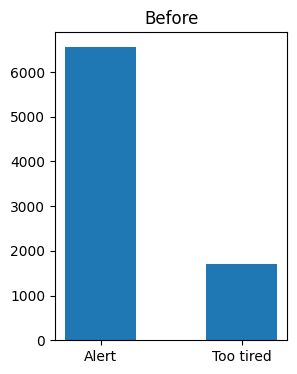

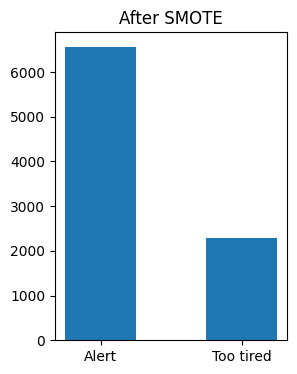

In [33]:
plt.figure(1)
fig = plt.figure(figsize = (3, 4))
plt.bar(['Alert', 'Too tired'], counter_original.values(), width=0.5)
plt.title("Before")

plt.figure(2)
fig = plt.figure(figsize = (3, 4))
plt.bar(['Alert', 'Too tired'], counter.values(), width=0.5)
plt.title("After SMOTE")

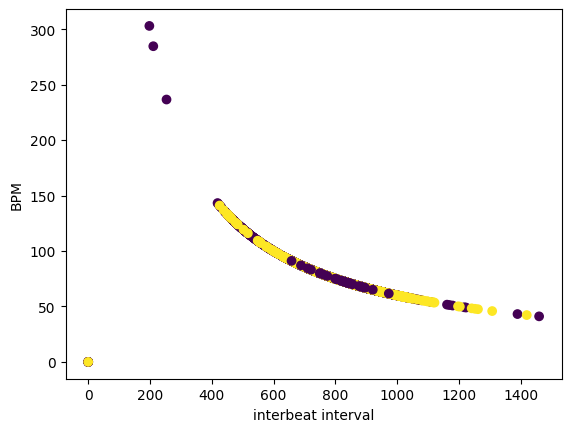

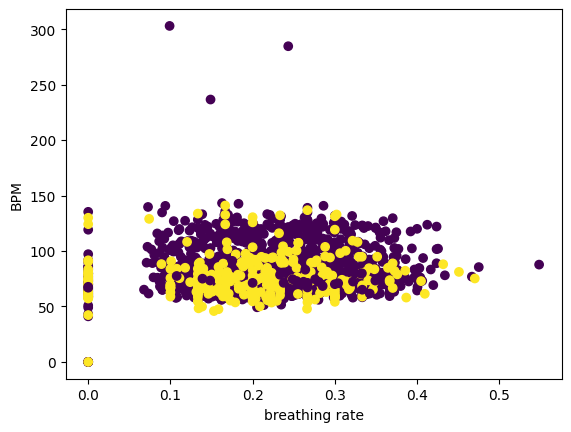

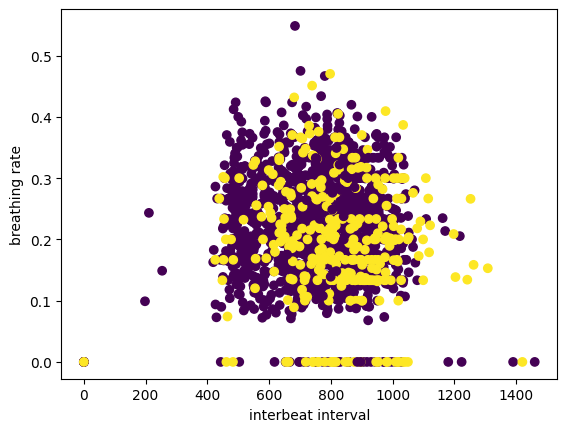

In [34]:
bpm = []
ibi = []
breath = []

for row in x_train[:2000]:
    bpm.append(row[0])
    ibi.append(row[1])
    breath.append(row[2])

plt.figure(1)
plt.scatter(ibi, bpm, c=y_train[:2000])
plt.xlabel('interbeat interval')
plt.ylabel('BPM')

plt.figure(2)
plt.scatter(breath, bpm, c=y_train[:2000])
plt.xlabel('breathing rate')
plt.ylabel('BPM')

plt.figure(3)
plt.scatter(ibi, breath, c=y_train[:2000])
plt.xlabel('interbeat interval')
plt.ylabel('breathing rate')

plt.show()

<Axes: >

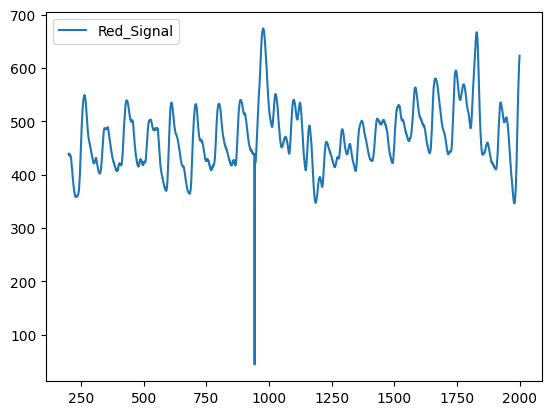

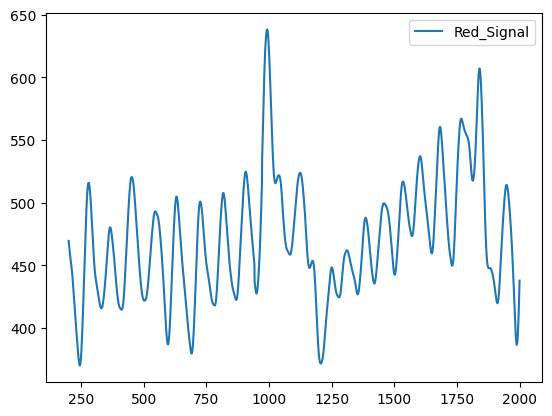

In [35]:
# Moving average
df_ppg1_1 = pd.read_csv('/content/drive/MyDrive/archive/gamer1-ppg-2000-01-01.csv', encoding='utf-8')
clean1_1 = df_ppg1_1.copy()
clean1_1['Red_Signal'] = df_ppg1_1.Red_Signal.rolling(30, min_periods=1).mean()

df_ppg1_1.iloc[200:2000].plot()
clean1_1.iloc[200:2000].plot()

(230.0, 250.0)

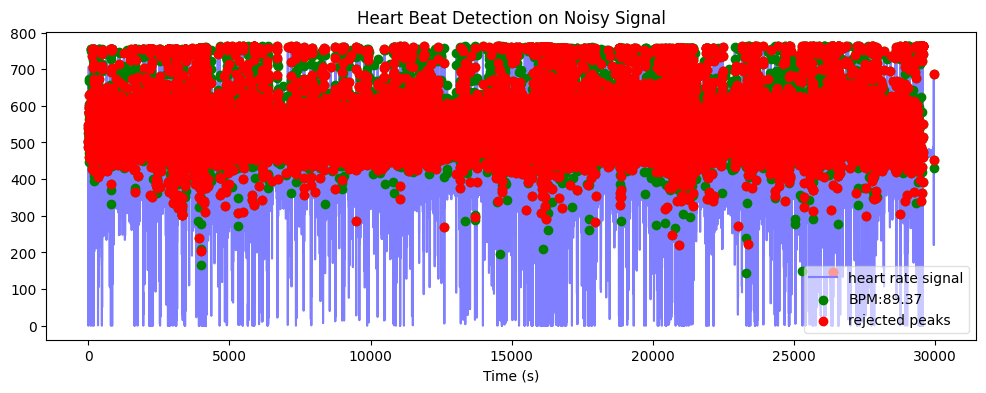

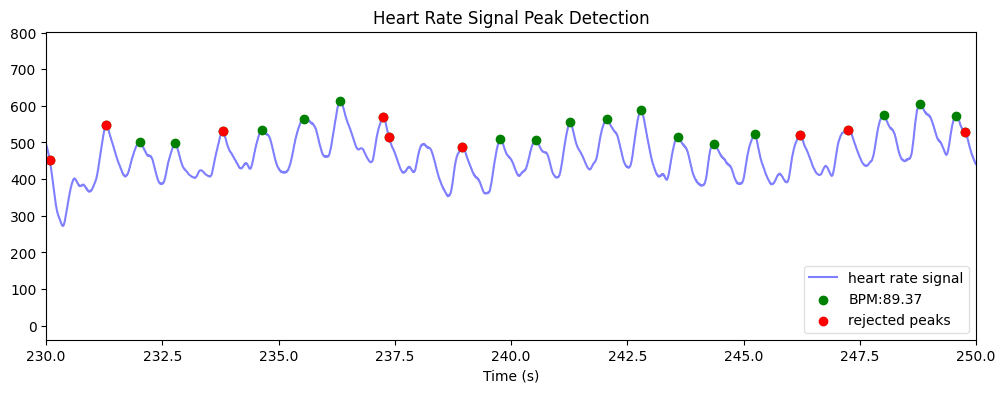

In [36]:
hrdata = hp.get_data('/content/drive/MyDrive/archive/gamer1-ppg-2000-01-01.csv', column_name='Red_Signal')
working_data, measures = hp.process(hrdata, sample_rate=100)
hp.plotter(working_data, measures, title='Heart Beat Detection on Noisy Signal', figsize=(12,4))

#zoomed in
hp.plotter(working_data, measures, figsize=(12,4))
plt.xlim(230, 250)

# Classification algorithms

In [37]:
algorithms = ['Decision tree', 'Random forest', 'KNN', 'Gaussian Naive Bayes', 'Multinomial Naive Bayes']

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [39]:
dt = DecisionTreeClassifier(criterion='gini', max_depth = 3, random_state=8).fit(x_train, y_train)

In [40]:
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=0).fit(x_train, y_train)

In [41]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)

In [42]:
gnb = GaussianNB().fit(x_train, y_train)

In [43]:
mnb = MultinomialNB().fit(x_train, y_train)

In [44]:
models = [dt, rf, knn, gnb, mnb]

In [45]:
accuracy_df = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1-score'])
results = []


for i in range(len(models)):
    prediction = models[i].predict(x_test)

    print(algorithms[i], "confusion matrix")
    print(confusion_matrix(y_test, prediction))

    recall = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    acc = accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    accuracy_df = accuracy_df.append({'model': algorithms[i], 'accuracy': acc, 'precision' : precision, 'recall' : recall, 'f1-score' : f1}, ignore_index=True)

print(accuracy_df)

Decision tree confusion matrix
[[2068    0]
 [ 277    1]]
Random forest confusion matrix
[[1998   70]
 [ 269    9]]


<ipython-input-45-9415487adc90>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df = accuracy_df.append({'model': algorithms[i], 'accuracy': acc, 'precision' : precision, 'recall' : recall, 'f1-score' : f1}, ignore_index=True)
<ipython-input-45-9415487adc90>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df = accuracy_df.append({'model': algorithms[i], 'accuracy': acc, 'precision' : precision, 'recall' : recall, 'f1-score' : f1}, ignore_index=True)


KNN confusion matrix
[[2044   24]
 [ 272    6]]
Gaussian Naive Bayes confusion matrix
[[2068    0]
 [ 278    0]]
Multinomial Naive Bayes confusion matrix
[[2040   28]
 [ 265   13]]
                     model  accuracy  precision    recall  f1-score
0            Decision tree  0.881927   1.000000  0.003597  0.007168
1            Random forest  0.855499   0.113924  0.032374  0.050420
2                      KNN  0.873828   0.200000  0.021583  0.038961
3     Gaussian Naive Bayes  0.881500   0.000000  0.000000  0.000000
4  Multinomial Naive Bayes  0.875107   0.317073  0.046763  0.081505


<ipython-input-45-9415487adc90>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df = accuracy_df.append({'model': algorithms[i], 'accuracy': acc, 'precision' : precision, 'recall' : recall, 'f1-score' : f1}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-45-9415487adc90>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  accuracy_df = accuracy_df.append({'model': algorithms[i], 'accuracy': acc, 'precision' : precision, 'recall' : recall, 'f1-score' : f1}, ignore_index=True)
<ipython-input-45-9415487adc90>:15: FutureWarning: The 

In [46]:
counter = Counter(y_test)
print(counter)

Counter({0: 2068, 1: 278})


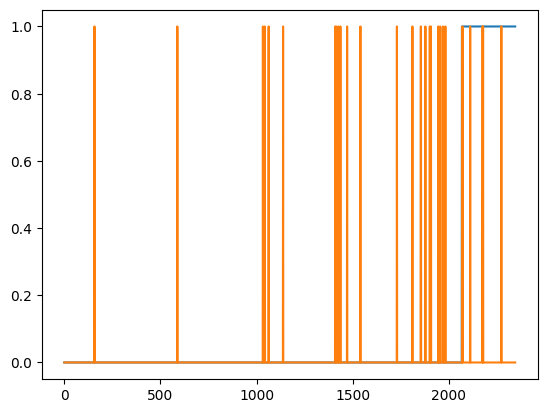

In [47]:
plt.plot(y_test)
plt.plot(knn.predict(x_test))
#plt.plot(dt.predict(x_test))
#plt.plot(rf.predict(x_test))

# Neural Network

In [48]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

In [49]:
classifier = Sequential()
classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu'))

classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fitting the Neural Network on the training data
classifier.fit(np.array(x_train),np.array(y_train), batch_size=15 , validation_split=0.2, shuffle=True, epochs=10, verbose=1)

Epoch 1/10
473/473 [==============================] - 2s 3ms/step - loss: 0.5128 - accuracy: 0.7975 - val_loss: 0.9547 - val_accuracy: 0.4791
Epoch 2/10
473/473 [==============================] - 1s 2ms/step - loss: 0.4950 - accuracy: 0.8062 - val_loss: 1.0190 - val_accuracy: 0.4791
Epoch 3/10
473/473 [==============================] - 1s 3ms/step - loss: 0.4942 - accuracy: 0.8062 - val_loss: 0.9186 - val_accuracy: 0.4791
Epoch 4/10
473/473 [==============================] - 1s 2ms/step - loss: 0.4941 - accuracy: 0.8062 - val_loss: 0.9604 - val_accuracy: 0.4791
Epoch 5/10
473/473 [==============================] - 1s 2ms/step - loss: 0.4936 - accuracy: 0.8062 - val_loss: 1.0534 - val_accuracy: 0.4791
Epoch 6/10
473/473 [==============================] - 1s 3ms/step - loss: 0.4938 - accuracy: 0.8062 - val_loss: 0.9121 - val_accuracy: 0.4791
Epoch 7/10
473/473 [==============================] - 1s 2ms/step - loss: 0.4931 - accuracy: 0.8062 - val_loss: 0.9169 - val_accuracy: 0.4791
Epoch 

In [50]:
acc = classifier.evaluate(np.array(x_test), np.array(y_test))
print(acc)

74/74 [==============================] - 0s 2ms/step - loss: 0.3904 - accuracy: 0.8815
[0.39039871096611023, 0.8815004229545593]


Epoch 1/10
442/442 [==============================] - 3s 5ms/step - loss: 0.5117 - accuracy: 0.7926 - val_loss: 0.5067 - val_accuracy: 0.7941
Epoch 2/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5115 - accuracy: 0.7926 - val_loss: 0.5078 - val_accuracy: 0.7941
Epoch 3/10
442/442 [==============================] - 2s 5ms/step - loss: 0.5114 - accuracy: 0.7926 - val_loss: 0.5100 - val_accuracy: 0.7941
Epoch 4/10
442/442 [==============================] - 1s 2ms/step - loss: 0.5116 - accuracy: 0.7926 - val_loss: 0.5105 - val_accuracy: 0.7941
Epoch 5/10
442/442 [==============================] - 1s 2ms/step - loss: 0.5108 - accuracy: 0.7926 - val_loss: 0.5091 - val_accuracy: 0.7941
Epoch 6/10
442/442 [==============================] - 1s 2ms/step - loss: 0.5111 - accuracy: 0.7926 - val_loss: 0.5107 - val_accuracy: 0.7941
Epoch 7/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5106 - accuracy: 0.7926 - val_loss: 0.5094 - val_accuracy: 0.7941
Epoch 

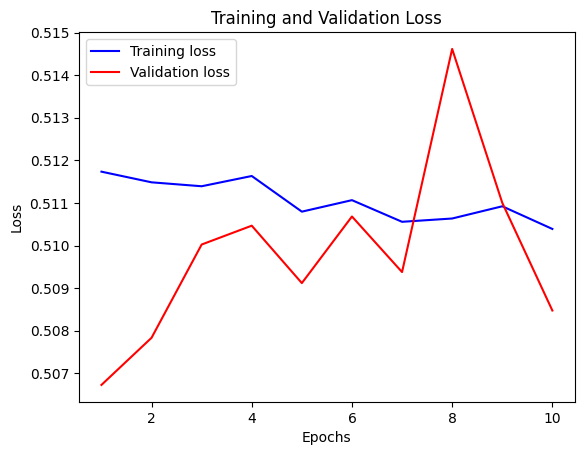

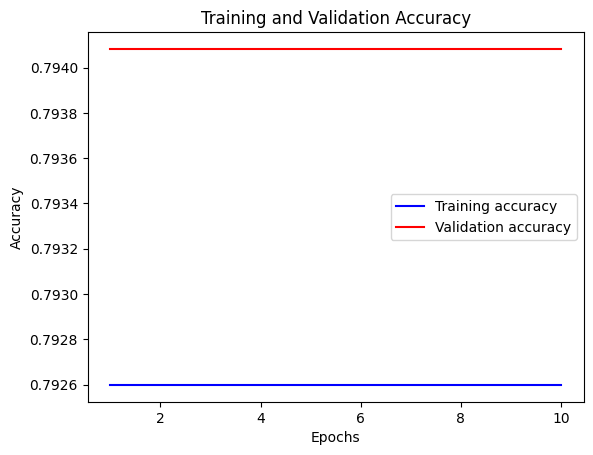

In [64]:
import matplotlib.pyplot as plt

# fitting the Neural Network on the training data
history = classifier.fit(np.array(x_train), np.array(y_train), batch_size=15, validation_split=0.2, shuffle=True, epochs=10, verbose=1)

# Obtain accuracy and loss values during training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Draw loss values on training and validation sets
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')  # Solid Line Representation Training Loss
plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # solid line representation verification loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Draw accuracy on training and validation sets
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')  # Solid Line Representation Training Accuracy
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')  # solid line representation verification accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [52]:
classifier2 = Sequential()
classifier2.add(Dense(units=12,kernel_initializer='uniform', activation='tanh'))

classifier2.add(Dense(units=9,activation='sigmoid'))

classifier2.add(Dense(units=6,activation='sigmoid'))

classifier2.add(Dense(units=3,activation='sigmoid'))

classifier2.add(Dense(units=1, activation='sigmoid'))

classifier2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fitting the Neural Network on the training data
classifier2.fit(np.array(x_train),np.array(y_train), batch_size=7 , shuffle=True, epochs=10, verbose=1)

Epoch 1/10
1266/1266 [==============================] - 6s 3ms/step - loss: 0.6648 - accuracy: 0.6264
Epoch 2/10
1266/1266 [==============================] - 3s 3ms/step - loss: 0.5776 - accuracy: 0.7408
Epoch 3/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5726 - accuracy: 0.7408
Epoch 4/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5724 - accuracy: 0.7408
Epoch 5/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5723 - accuracy: 0.7408
Epoch 6/10
1266/1266 [==============================] - 4s 3ms/step - loss: 0.5723 - accuracy: 0.7408
Epoch 7/10
1266/1266 [==============================] - 5s 4ms/step - loss: 0.5723 - accuracy: 0.7408
Epoch 8/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5723 - accuracy: 0.7408
Epoch 9/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.5723 - accuracy: 0.7408
Epoch 10/10
1266/1266 [==============================] - 3s 2ms/step - loss: 0.572

In [53]:
classifier2.predict(np.array(x_test))

74/74 [==============================] - 0s 2ms/step


array([[0.26133776],
       [0.26133776],
       [0.26133776],
       ...,
       [0.26133776],
       [0.26133776],
       [0.26133776]], dtype=float32)

Epoch 1/10
1183/1183 [==============================] - 5s 4ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 2/10
1183/1183 [==============================] - 6s 5ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 3/10
1183/1183 [==============================] - 3s 3ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 4/10
1183/1183 [==============================] - 3s 2ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 5/10
1183/1183 [==============================] - 3s 2ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 6/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 7/10
1183/1183 [==============================] - 3s 3ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 8/10
1183/1183 [==============================] - 4s 3ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 9/10
1183/1183 [==============================] - 3s 2ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 10/10
1183/1183 [==============================] - 3s 2ms/step - loss: 0.510

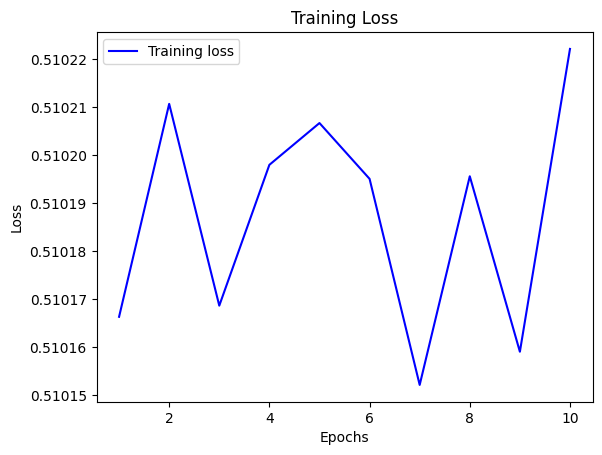

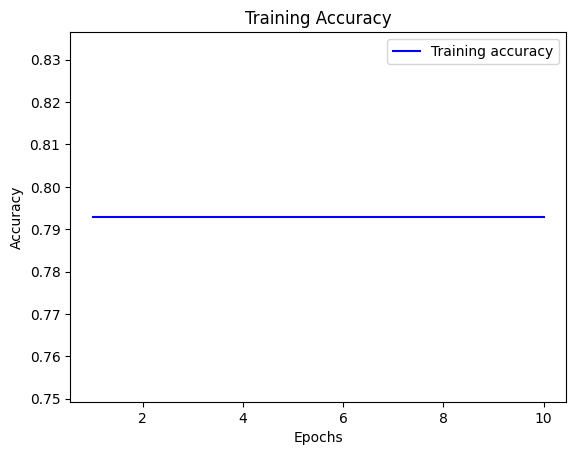

In [63]:
import matplotlib.pyplot as plt

# fitting the Neural Network on the training data
history2 = classifier2.fit(np.array(x_train), np.array(y_train), batch_size=7, shuffle=True, epochs=10, verbose=1)

# Obtain accuracy and loss values during training
train_loss = history2.history['loss']
train_acc = history2.history['accuracy']

# Draw the loss value on the training set
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')  # Solid Line Representation Training Loss
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Drawing Accuracy on Training Sets
plt.plot(epochs, train_acc, 'b-', label='Training accuracy') # Solid Line Representation Training Accuracy
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [54]:
import pandas as pd
import numpy as np

x_train = []
y_train = []

for i in range(4):
    x, y = read_gamer(ppg_train[i*2], ppg_train[i*2+1], annotations_train[i], features)

    for line in x:
        x_train.append(line)
    y_train = y_train + y
# Read training data data and testing data
train_data = pd.read_csv('/content/drive/MyDrive/archive/gamer5-ppg-2000-01-01.csv', names=['bpm', 'ibi', 'breathingrate'])
test_data = pd.read_csv('/content/drive/MyDrive/archive/gamer5-ppg-2000-01-01.csv',names=['bpm', 'ibi', 'breathingrate'])
annotations = pd.read_csv('/content/drive/MyDrive/archive/gamer5-annotations.csv',names=['bpm', 'ibi', 'breathingrate'])

dt = DecisionTreeClassifier(criterion='gini', max_depth = 3, random_state=8).fit(x_train, y_train)
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=0).fit(x_train, y_train)
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)
gnb = GaussianNB().fit(x_train, y_train)


mnb = MultinomialNB().fit(x_train, y_train)
models = [dt, rf, knn, gnb, mnb]

/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:5288: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: 

In [55]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)


classifier_lstm = Sequential()
classifier_lstm.add(LSTM(units=10, input_shape=(x_train.shape[1], 1)))
classifier_lstm.add(Dense(units=6, activation='relu'))
classifier_lstm.add(Dense(units=1, activation='sigmoid'))
classifier_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier_lstm.fit(np.array(x_train), np.array(y_train), batch_size=15, validation_split=0.2, shuffle=True, epochs=10, verbose=1)

Epoch 1/10
442/442 [==============================] - 7s 9ms/step - loss: 0.5145 - accuracy: 0.7926 - val_loss: 0.5090 - val_accuracy: 0.7941
Epoch 2/10
442/442 [==============================] - 3s 6ms/step - loss: 0.5111 - accuracy: 0.7926 - val_loss: 0.5095 - val_accuracy: 0.7941
Epoch 3/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5111 - accuracy: 0.7926 - val_loss: 0.5098 - val_accuracy: 0.7941
Epoch 4/10
442/442 [==============================] - 2s 5ms/step - loss: 0.5113 - accuracy: 0.7926 - val_loss: 0.5098 - val_accuracy: 0.7941
Epoch 5/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5107 - accuracy: 0.7926 - val_loss: 0.5101 - val_accuracy: 0.7941
Epoch 6/10
442/442 [==============================] - 2s 5ms/step - loss: 0.5109 - accuracy: 0.7926 - val_loss: 0.5095 - val_accuracy: 0.7941
Epoch 7/10
442/442 [==============================] - 2s 5ms/step - loss: 0.5105 - accuracy: 0.7926 - val_loss: 0.5098 - val_accuracy: 0.7941
Epoch 

Epoch 1/10
442/442 [==============================] - 4s 10ms/step - loss: 0.5110 - accuracy: 0.7926 - val_loss: 0.5088 - val_accuracy: 0.7941
Epoch 2/10
442/442 [==============================] - 5s 11ms/step - loss: 0.5110 - accuracy: 0.7926 - val_loss: 0.5088 - val_accuracy: 0.7941
Epoch 3/10
442/442 [==============================] - 4s 9ms/step - loss: 0.5111 - accuracy: 0.7926 - val_loss: 0.5087 - val_accuracy: 0.7941
Epoch 4/10
442/442 [==============================] - 5s 10ms/step - loss: 0.5112 - accuracy: 0.7926 - val_loss: 0.5087 - val_accuracy: 0.7941
Epoch 5/10
442/442 [==============================] - 3s 6ms/step - loss: 0.5107 - accuracy: 0.7926 - val_loss: 0.5087 - val_accuracy: 0.7941
Epoch 6/10
442/442 [==============================] - 3s 7ms/step - loss: 0.5110 - accuracy: 0.7926 - val_loss: 0.5087 - val_accuracy: 0.7941
Epoch 7/10
442/442 [==============================] - 2s 5ms/step - loss: 0.5106 - accuracy: 0.7926 - val_loss: 0.5090 - val_accuracy: 0.7941
Epo

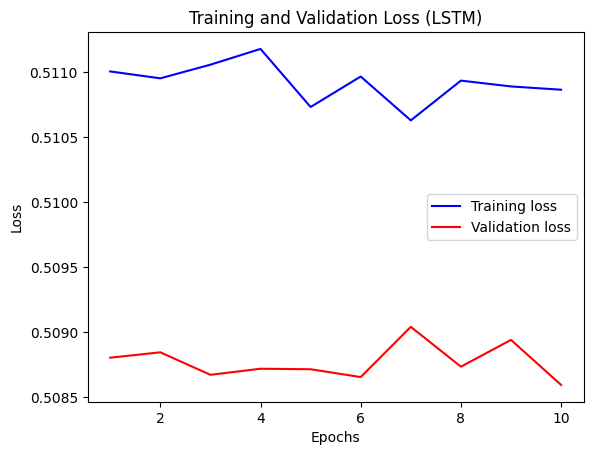

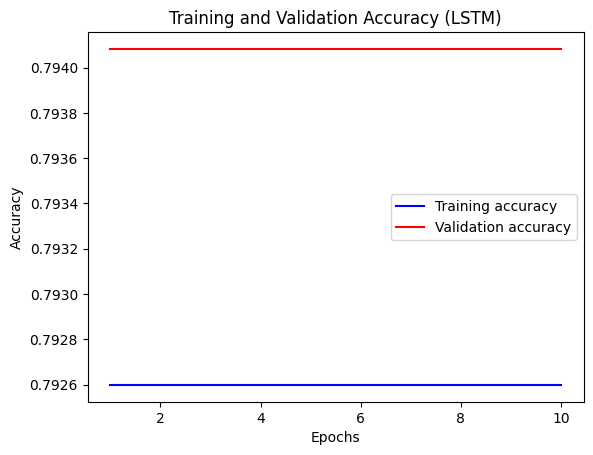

In [62]:
import matplotlib.pyplot as plt

# fitting the LSTM on the training data
history_lstm = classifier_lstm.fit(np.array(x_train), np.array(y_train), batch_size=15, validation_split=0.2, shuffle=True, epochs=10, verbose=1)

# Obtain accuracy and loss values during training
train_loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
train_acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']

# Draw loss values on training and validation sets
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')  # Solid Line Representation Training Loss
plt.plot(epochs, val_loss, 'r-', label='Validation loss')  # solid line representation verification loss
plt.title('Training and Validation Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Draw accuracy on training and validation sets
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')  # Solid Line Representation Training Accuracy
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')  # solid line representation verification accuracy
plt.title('Training and Validation Accuracy (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [56]:
x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)


classifier_lstm2 = Sequential()
classifier_lstm2.add(LSTM(units=10, input_shape=(x_train.shape[1], 1)))
classifier_lstm2.add(Dense(units=6, activation='relu'))
classifier_lstm2.add(Dense(units=1, activation='sigmoid'))
classifier_lstm2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

classifier_lstm2.fit(np.array(x_train),np.array(y_train), batch_size=7 , shuffle=True, epochs=10, verbose=1)

Epoch 1/10
1183/1183 [==============================] - 17s 9ms/step - loss: 0.5206 - accuracy: 0.7858
Epoch 2/10
1183/1183 [==============================] - 4s 4ms/step - loss: 0.5108 - accuracy: 0.7929
Epoch 3/10
1183/1183 [==============================] - 5s 5ms/step - loss: 0.5109 - accuracy: 0.7929
Epoch 4/10
1183/1183 [==============================] - 6s 5ms/step - loss: 0.5111 - accuracy: 0.7929
Epoch 5/10
1183/1183 [==============================] - 4s 4ms/step - loss: 0.5111 - accuracy: 0.7929
Epoch 6/10
1183/1183 [==============================] - 5s 4ms/step - loss: 0.5106 - accuracy: 0.7929
Epoch 7/10
1183/1183 [==============================] - 7s 6ms/step - loss: 0.5109 - accuracy: 0.7929
Epoch 8/10
1183/1183 [==============================] - 5s 4ms/step - loss: 0.5107 - accuracy: 0.7929
Epoch 9/10
1183/1183 [==============================] - 5s 4ms/step - loss: 0.5101 - accuracy: 0.7929
Epoch 10/10
1183/1183 [==============================] - 6s 5ms/step - loss: 0.51

Epoch 1/10
1183/1183 [==============================] - 10s 8ms/step - loss: 0.5104 - accuracy: 0.7929
Epoch 2/10
1183/1183 [==============================] - 11s 9ms/step - loss: 0.5107 - accuracy: 0.7929
Epoch 3/10
1183/1183 [==============================] - 4s 4ms/step - loss: 0.5103 - accuracy: 0.7929
Epoch 4/10
1183/1183 [==============================] - 5s 4ms/step - loss: 0.5107 - accuracy: 0.7929
Epoch 5/10
1183/1183 [==============================] - 7s 6ms/step - loss: 0.5106 - accuracy: 0.7929
Epoch 6/10
1183/1183 [==============================] - 5s 4ms/step - loss: 0.5106 - accuracy: 0.7929
Epoch 7/10
1183/1183 [==============================] - 4s 4ms/step - loss: 0.5106 - accuracy: 0.7929
Epoch 8/10
1183/1183 [==============================] - 6s 5ms/step - loss: 0.5105 - accuracy: 0.7929
Epoch 9/10
1183/1183 [==============================] - 5s 5ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 10/10
1183/1183 [==============================] - 4s 4ms/step - loss: 0.5

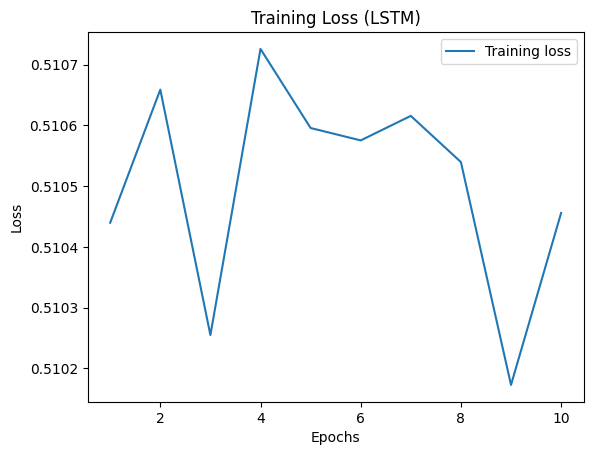

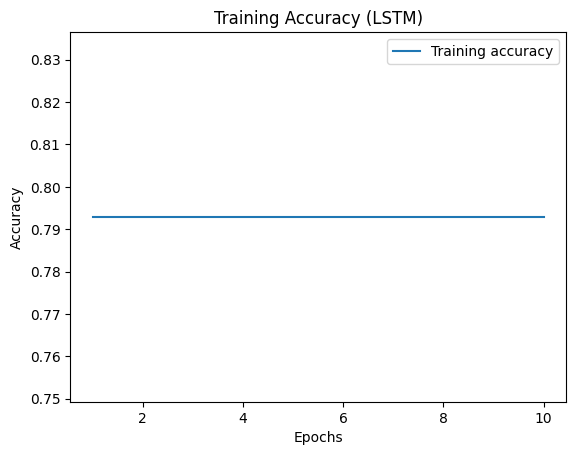

In [61]:
import matplotlib.pyplot as plt

# fitting the LSTM on the training data
history_lstm2 = classifier_lstm2.fit(np.array(x_train), np.array(y_train), batch_size=7, shuffle=True, epochs=10, verbose=1)

# Obtain accuracy and loss values during training
train_loss = history_lstm2.history['loss']
train_acc = history_lstm2.history['accuracy']

# Draw the loss value on the training set
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss', linestyle='solid')  # Use solid lines to represent loss values
plt.title('Training Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Drawing Accuracy on Training Sets
plt.plot(epochs, train_acc, label='Training accuracy', linestyle='solid')  # Use solid lines to represent accuracy
plt.title('Training Accuracy (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [65]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Assuming x_train and y_train are your training data and labels

# Obtain the number of samples and features
num_samples = len(x_train)
num_features = len(x_train[0])

# Build the neural network model
classifier = Sequential()
classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu', input_shape=(num_features,)))  # Use num_features as input shape
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compile the model
classifier.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
classifier.fit(np.array(x_train), np.array(y_train), batch_size=15, validation_split=0.2, shuffle=True, epochs=10, verbose=1)


Epoch 1/10
442/442 [==============================] - 7s 9ms/step - loss: 0.5223 - accuracy: 0.7924 - val_loss: 0.5013 - val_accuracy: 0.7941
Epoch 2/10
442/442 [==============================] - 2s 5ms/step - loss: 0.5154 - accuracy: 0.7926 - val_loss: 0.5023 - val_accuracy: 0.7941
Epoch 3/10
442/442 [==============================] - 3s 6ms/step - loss: 0.5142 - accuracy: 0.7926 - val_loss: 0.5055 - val_accuracy: 0.7941
Epoch 4/10
442/442 [==============================] - 2s 5ms/step - loss: 0.5148 - accuracy: 0.7926 - val_loss: 0.5023 - val_accuracy: 0.7941
Epoch 5/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5147 - accuracy: 0.7926 - val_loss: 0.5046 - val_accuracy: 0.7941
Epoch 6/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5154 - accuracy: 0.7926 - val_loss: 0.5026 - val_accuracy: 0.7941
Epoch 7/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5141 - accuracy: 0.7926 - val_loss: 0.5058 - val_accuracy: 0.7941
Epoch 

Epoch 1/10
442/442 [==============================] - 1s 3ms/step - loss: 0.5138 - accuracy: 0.7926 - val_loss: 0.5063 - val_accuracy: 0.7941
Epoch 2/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5137 - accuracy: 0.7926 - val_loss: 0.5055 - val_accuracy: 0.7941
Epoch 3/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5133 - accuracy: 0.7926 - val_loss: 0.5029 - val_accuracy: 0.7941
Epoch 4/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5139 - accuracy: 0.7926 - val_loss: 0.5034 - val_accuracy: 0.7941
Epoch 5/10
442/442 [==============================] - 2s 4ms/step - loss: 0.5142 - accuracy: 0.7926 - val_loss: 0.5071 - val_accuracy: 0.7941
Epoch 6/10
442/442 [==============================] - 1s 2ms/step - loss: 0.5135 - accuracy: 0.7926 - val_loss: 0.5033 - val_accuracy: 0.7941
Epoch 7/10
442/442 [==============================] - 1s 2ms/step - loss: 0.5130 - accuracy: 0.7926 - val_loss: 0.5055 - val_accuracy: 0.7941
Epoch 

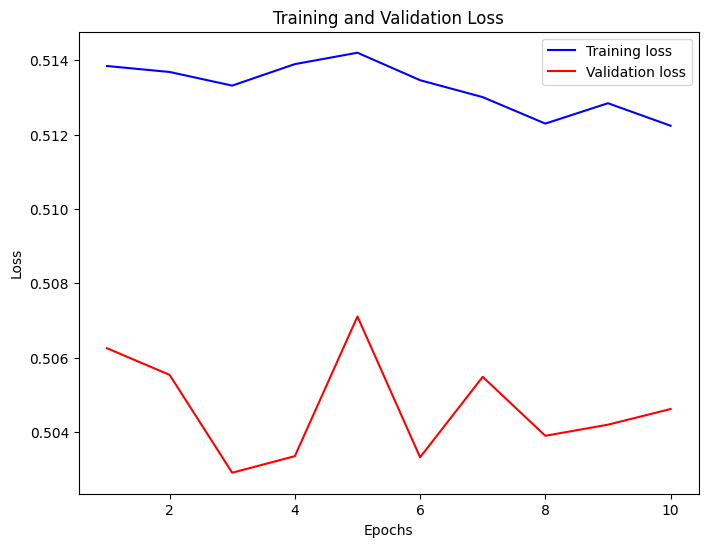

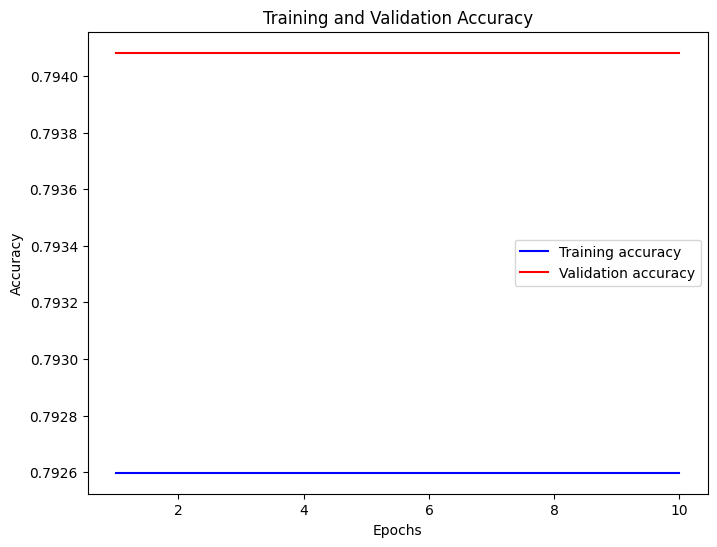

In [66]:
import matplotlib.pyplot as plt

# Train the model and obtain metrics during training
history = classifier.fit(np.array(x_train), np.array(y_train), batch_size=15, validation_split=0.2, shuffle=True, epochs=10, verbose=1)

# Obtain loss and accuracy metrics during training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [68]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Assuming x_train and y_train are your training data and labels

# Obtain the number of samples and features
num_samples = len(x_train)
num_features = len(x_train[0])

# Build the neural network model
classifier2 = Sequential()
classifier2.add(Dense(units=10, kernel_initializer='uniform', activation='relu', input_shape=(num_features,)))  # Using num_features as input shape
classifier2.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
classifier2.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compile the model
classifier2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
classifier2.fit(np.array(x_train), np.array(y_train), batch_size=7, shuffle=True, epochs=10, verbose=1)


Epoch 1/10
1183/1183 [==============================] - 11s 6ms/step - loss: 0.5169 - accuracy: 0.7929
Epoch 2/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5149 - accuracy: 0.7929
Epoch 3/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5132 - accuracy: 0.7929
Epoch 4/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5125 - accuracy: 0.7929
Epoch 5/10
1183/1183 [==============================] - 4s 3ms/step - loss: 0.5127 - accuracy: 0.7929
Epoch 6/10
1183/1183 [==============================] - 5s 4ms/step - loss: 0.5125 - accuracy: 0.7929
Epoch 7/10
1183/1183 [==============================] - 4s 3ms/step - loss: 0.5124 - accuracy: 0.7929
Epoch 8/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5123 - accuracy: 0.7929
Epoch 9/10
1183/1183 [==============================] - 3s 2ms/step - loss: 0.5116 - accuracy: 0.7929
Epoch 10/10
1183/1183 [==============================] - 4s 3ms/step - loss: 0.51

Epoch 1/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5106 - accuracy: 0.7929
Epoch 2/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5108 - accuracy: 0.7929
Epoch 3/10
1183/1183 [==============================] - 3s 3ms/step - loss: 0.5106 - accuracy: 0.7929
Epoch 4/10
1183/1183 [==============================] - 3s 3ms/step - loss: 0.5097 - accuracy: 0.7929
Epoch 5/10
1183/1183 [==============================] - 3s 2ms/step - loss: 0.5099 - accuracy: 0.7929
Epoch 6/10
1183/1183 [==============================] - 2s 2ms/step - loss: 0.5106 - accuracy: 0.7929
Epoch 7/10
1183/1183 [==============================] - 3s 2ms/step - loss: 0.5100 - accuracy: 0.7929
Epoch 8/10
1183/1183 [==============================] - 3s 3ms/step - loss: 0.5104 - accuracy: 0.7929
Epoch 9/10
1183/1183 [==============================] - 3s 3ms/step - loss: 0.5102 - accuracy: 0.7929
Epoch 10/10
1183/1183 [==============================] - 4s 3ms/step - loss: 0.509

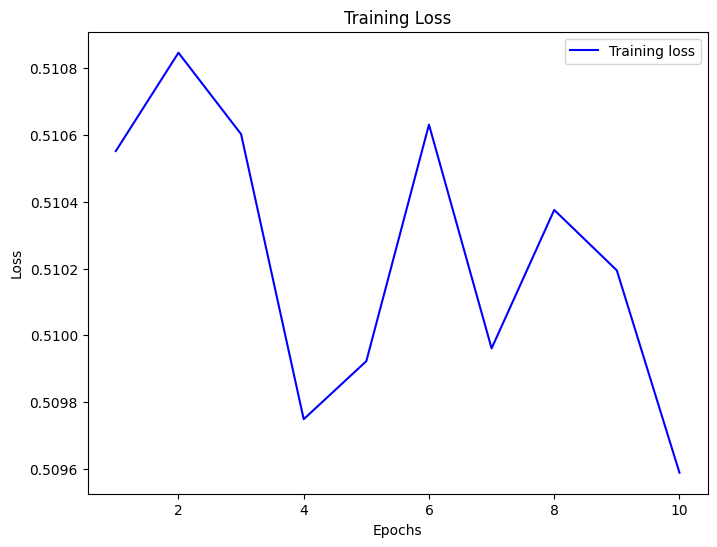

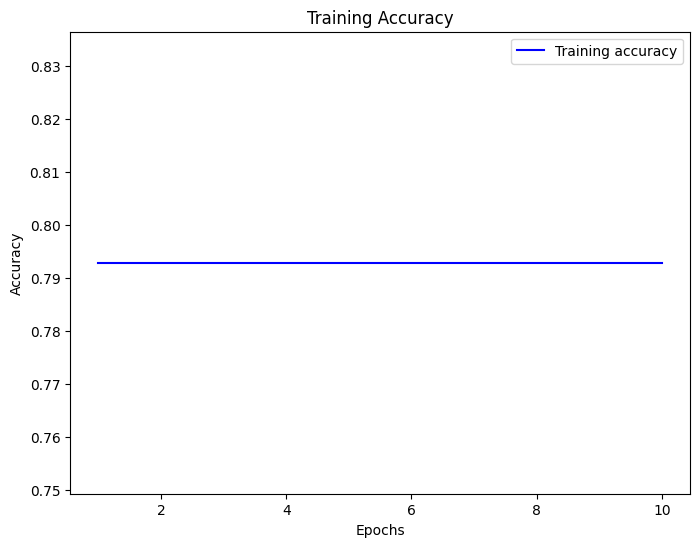

In [69]:
import matplotlib.pyplot as plt

# Train the model and obtain metrics during training
history2 = classifier2.fit(np.array(x_train), np.array(y_train), batch_size=7, shuffle=True, epochs=10, verbose=1)

# Obtain loss and accuracy metrics during training
train_loss = history2.history['loss']
train_acc = history2.history['accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot training loss on the training set
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy on the training set
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
